In [1]:
#Import modules

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from numpy import arange, log10


### Summary table

In [14]:
links = pd.read_csv('./buyer_seller_link_value.csv')
links = links.loc[links.VART > 1000]
links_count = links.groupby('YEAR').agg({'VART': 'count', 'ID': 'nunique', 'VAT': 'nunique'})
links_count = links_count.rename(columns = {'VART': 'pairs', 'ID': 'FR sellers', 'VAT': 'foreign buyers'})
links_pct_change = 100*links_count.pct_change().round(4).fillna('')

links_summary = pd.concat([links_count,links_pct_change], axis = 1)
links_summary.columns = pd.MultiIndex.from_product([['count', 'yearly pct change'], links_count.columns])
links_summary
# print(links_summary.to_latex())

count                           yearly pct change             \
       pairs FR sellers foreign buyers             pairs FR sellers   
YEAR                                                                  
1997  824529      52062         352398                                
1998  853034      53380         356449              3.46       2.53   

                     
     foreign buyers  
YEAR                 
1997                 
1998           1.15

### Value by buyer-seller pair characteristic

In [3]:
links = pd.read_csv('./buyer_seller_link_value.csv')
links = links.loc[links.VART > 1000]

links['log_VART'] = log10(links.VART)#.replace(-inf, nan).dropna()
# links['bin'], bins_x = pd.cut(links['log_VART'], 90, retbins=True)

In [7]:
links_y = links.groupby(['ID', 'VAT'])[['VART']].mean().reset_index()

ID_chars = links_y.groupby('ID').agg({'VAT': 'nunique', 'VART': sum}).rename(columns = {'VART': 'log_VART', 'VAT': 'ID_degree'})
ID_chars = log10(ID_chars).reset_index()

VAT_chars = links_y.groupby('VAT').agg({'ID': 'nunique', 'VART': sum}).rename(columns = {'VART': 'log_VART', 'ID': 'VAT_degree'})
VAT_chars = log10(VAT_chars).reset_index()


In [8]:
links_val = links_y.merge(ID_chars[['ID','log_VART', 'ID_degree']], on = 'ID').merge(VAT_chars[['VAT', 'log_VART', 'VAT_degree']], on = 'VAT')
links_val = links_val.rename(columns = {'log_VART_x': 'log_VART_ID', 'log_VART_y': 'log_VART_VAT'})

In [9]:
print links_val.VAT_degree.max()
print links_val.ID_degree.max()

3.71999382637
3.59802407233


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


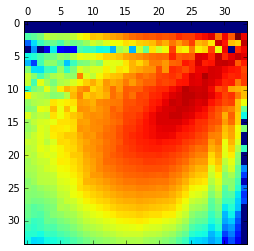

In [25]:
from numpy import arange

y = 1997

links_y = links.loc[links.YEAR == y]
df = pd.read_csv('./firm_sizes_99.csv'); firm_sizes_y = df.loc[df.YEAR == y]
firm_sizes_y['log_VART'] = log10(firm_sizes_y['VART'])
df = pd.read_csv('./buyr_sizes_99.csv'); buyr_sizes_y = df.loc[df.YEAR == y]
buyr_sizes_y['log_VART'] = log10(buyr_sizes_y['VART'])

links_val = links_y.merge(firm_sizes_y[['ID','log_VART']], on = 'ID').merge(buyr_sizes_y[['VAT', 'log_VART']], on = 'VAT')
links_val['x_bin'] = pd.cut(links_val['log_VART_x'], arange(3, 10, .2))
links_val['y_bin'] = pd.cut(links_val['log_VART_y'], arange(3, 10, .2))
result = links_val.groupby(['x_bin','y_bin'])[['VART']].sum()
plt.matshow(log10(result.unstack(0).sort_index(ascending = False)).fillna(3).values)


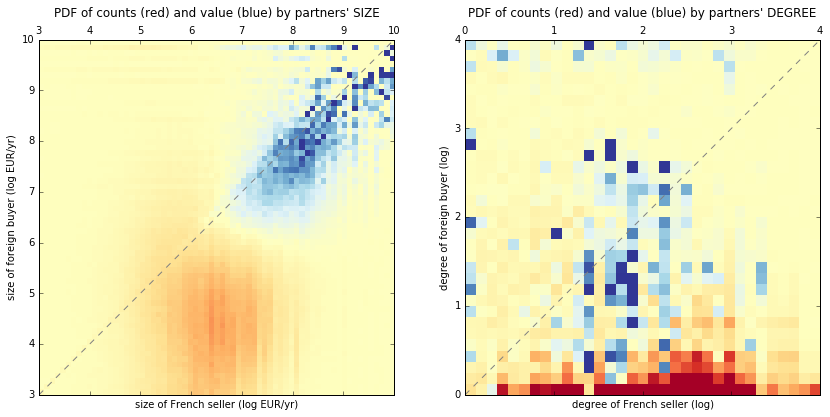

In [15]:
from numpy import arange
from matplotlib.colors import Normalize

bins = arange(3, 10, .1)
links_val['val_x_bin'] = pd.cut(links_val['log_VART_ID'], bins)
links_val['val_y_bin'] = pd.cut(links_val['log_VART_VAT'], bins)

bins_d = arange(-.1, 4, .1)
links_val['deg_x_bin'] = pd.cut(links_val['ID_degree'], bins_d)
links_val['deg_y_bin'] = pd.cut(links_val['VAT_degree'], bins_d)

fig, axs = plt.subplots(1, 2, figsize = (14, 7))

for i in [0, 1]:

    if i == 0:
        result = links_val.groupby(['val_x_bin','val_y_bin']).agg({'log_VART_ID': 'mean', 'log_VART_VAT': 'mean', 
                                                           'VART': 'sum', 'ID': 'count'})
    elif i == 1:
        result = links_val.groupby(['deg_x_bin','deg_y_bin']).agg({'ID_degree': 'mean', 'VAT_degree': 'mean', 
                                                           'VART': 'sum', 'ID': 'count'}) #ID is just a counter

    result['PDF_value'] = result['VART']/result['VART'].sum()
    result['PDF_count'] = result['ID']/result['ID'].sum() #ID is just a counter

    result_table = result.unstack(0).sort_index(ascending = False)

    value = result_table['PDF_value'].fillna(0).values
    count = result_table['PDF_count'].fillna(0).values

    ax = axs[i]
    extent = [(3, 10, 3, 10), (0, 4, 0, 4)][i]
    ax.matshow(value - count, extent=extent, cmap=plt.cm.RdYlBu, vmin = -0.003, vmax = .003)


axs[0].plot([3, 10], [3, 10], c = '.5', linestyle = '--')
axs[1].plot([0, 4], [0, 4], c = '.5', linestyle = '--')

axs[0].set_xlabel('size of French seller (log EUR/yr)')
axs[0].set_ylabel('size of foreign buyer (log EUR/yr)')
axs[0].set_title("PDF of counts (red) and value (blue) by partners' SIZE")
axs[1].set_xlabel('degree of French seller (log)')
axs[1].set_ylabel('degree of foreign buyer (log)')
axs[1].set_title("PDF of counts (red) and value (blue) by partners' DEGREE")
plt.show()